In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[i, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [ ]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[i, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [ ]:
dataset_root = "dataset"
t1_train_data = "/content/drive/MyDrive/data/T1"
image_size = 64
batch_size = 128
num_workers = 16
device = torch.device("cuda:0")

# Generator model configuration
latent_size = 128
feature_map_size = image_size//2

# Learning rate
lr = 0.0002
# beta 1 for Adam
beta1 = 0.5

# Number of training epochs
num_epochs = 500

In [ ]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = Data(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
real_batch = next(iter(dataloader))

torch.Size([128, 1, 64, 64])


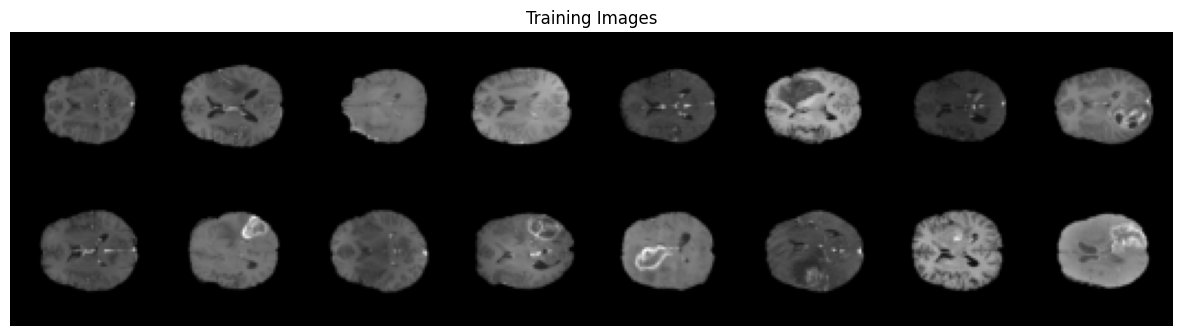

In [ ]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [ ]:
def weight_init(m):
    """Custom weight initialization called on netG and netD"""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.normal_(m.bias.data, 0)

In [ ]:
# Generator code
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # input: feature_map_size*16 x image_size/16 x image_size/16
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # input: feature_map_size*8 x image_size/8 x image_size/8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # input: feature_map_size*4 x image_size/4 x image_size/4
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # input: feature_map_size*2 x image_size/2 x image_size/2
            nn.ConvTranspose2d(feature_map_size, 1, 4, 2, 1, bias=False),
            nn.Tanh(),
            # output: 1 x image_size x image_size
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device)
netG.apply(weight_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: 1 x image_size x image_size
            nn.Conv2d(1, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2, True),
            # input: feature_map_size x image_size/2 x image_size/2
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, True),
            # input: feature_map_size*2 x image_size/4 x image_size/4
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, True),
            # input: feature_map_size*4 x image_size/8 x image_size/8
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, True),
            # input: feature_map_size*8 x image_size/16 x image_size/16
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output: 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device)
netD.apply(weight_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 1, kernel_size=(4, 

In [ ]:
critetion = nn.BCELoss()

# fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training loop

g_loss_hist = list()
d_loss_hist = list()
d_loss_real_hist = list()
d_loss_fake_hist = list()
psnr_hist = list()
ssim_hist = list()

best_psnr = -float("inf")
best_ssim = -float("inf")

best_g_weights = None
best_d_weights = None

print("Staring training loop...")
print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in dataloader
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Train with real batch
        real = data.to(device)
        b_size = real.size(0)

        # Update D network
        # maximize log(D(x)) using batch of real images
        # maximize log(1 - D(G(z))) using batch of fake images
        netD.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real).view(-1)
        errD_real = critetion(output, label)
        errD_real.backward()

        # Train with fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = critetion(output, label)
        errD_fake.backward()

        errD = errD_real + errD_fake
        d_loss_real_hist.append(errD_real.detach().cpu().numpy())
        d_loss_fake_hist.append(errD_fake.detach().cpu().numpy())
        d_loss_hist.append(errD.detach().cpu().numpy())
        optimizerD.step()

        # Train generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = critetion(output, label)
        errG.backward()

        g_loss_hist.append(errG.detach().cpu().numpy())
        optimizerG.step()

        # Save best model based on PSNR every iteration
        psnr_hist.append(
            compute_psnr(
                real.detach().cpu().numpy(),
                fake.detach().cpu().numpy()
            )
        )
        ssim_hist.append(
            compute_ssim(
                real.detach().cpu().numpy(),
                fake.detach().cpu().numpy()
            )
        )
        if ssim_hist[-1] > best_ssim:
            best_psnr = psnr_hist[-1]
            best_ssim = ssim_hist[-1]
            best_g_weights = netG.state_dict()
            best_d_weights = netD.state_dict()

    # Summarize performance every epoch
    tqdm.write("\n".join((
        f"epoch: {epoch}, Loss D: {d_loss_hist[-1]:.4f}, Loss G: {g_loss_hist[-1]:.4f} ",
        f"Loss D real: {d_loss_real_hist[-1]:.4f} ",
        f"Loss D fake: {d_loss_fake_hist[-1]:.4f} ",
        f"psnr: {psnr_hist[-1]:.4f}, best_psnr: {best_psnr:.4f} ",
        f"ssim: {ssim_hist[-1]:.4f}, best_ssim: {best_ssim:.4f} ",
    )))

        # Check how the generator is doing by saving G's output on fixed_noise
        # if (i % 24 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1))):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

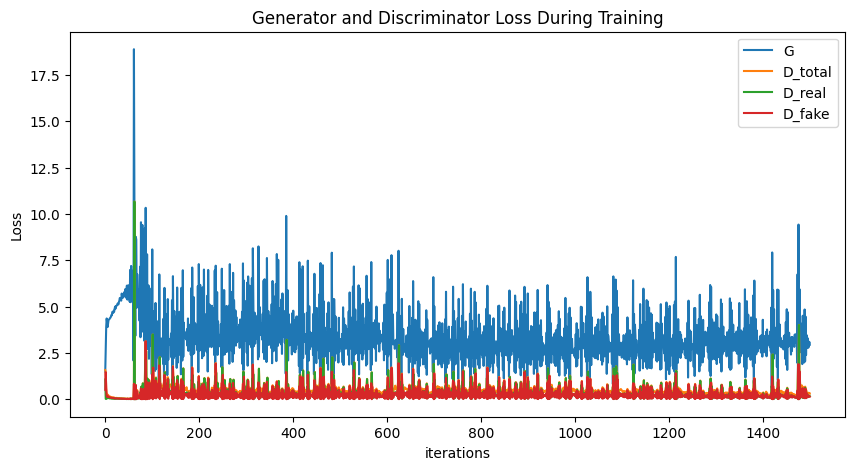

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_hist, label="G")
plt.plot(d_loss_hist, label="D_total")
plt.plot(d_loss_real_hist, label="D_real")
plt.plot(d_loss_fake_hist, label="D_fake")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

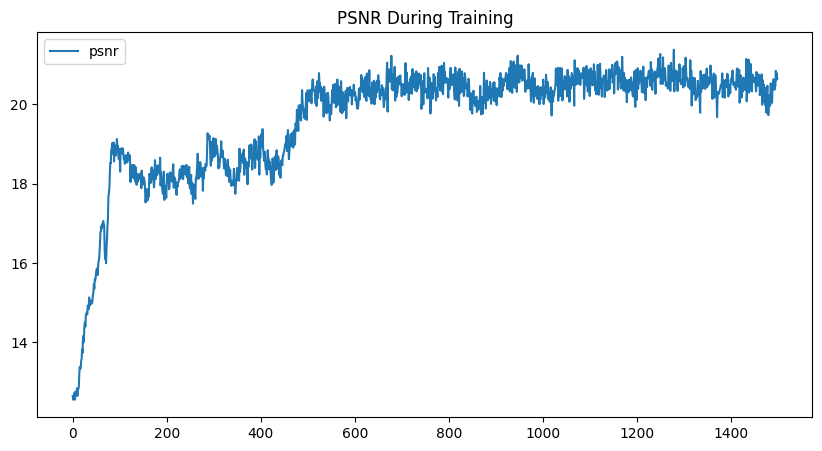

Best PSNR: 20.3716


In [ ]:
plt.figure(figsize=(10,5))
plt.title("PSNR During Training")
plt.plot(psnr_hist, label='psnr')
plt.legend()
plt.show()
print(f"Best PSNR: {best_psnr:.4f}")

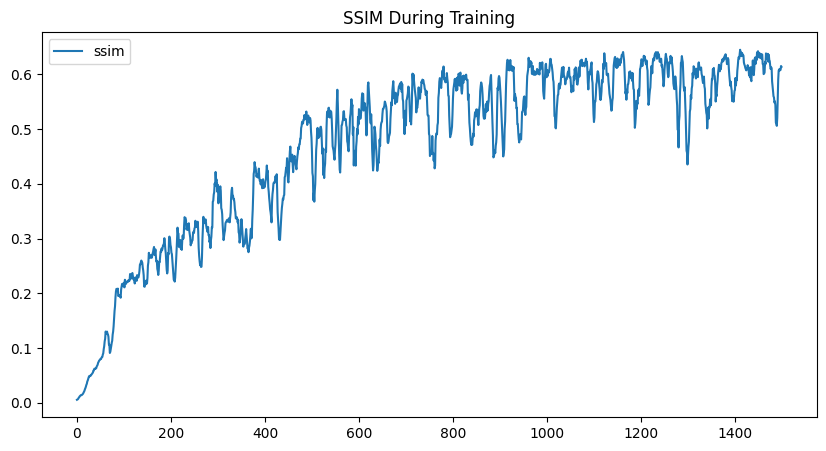

Best SSIM: 0.6448


In [ ]:
plt.figure(figsize=(10,5))
plt.title("SSIM During Training")
plt.plot(ssim_hist, label='ssim')
plt.legend()
plt.show()
print(f"Best SSIM: {best_ssim:.4f}")

In [ ]:
# Save models weights
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "/content/drive/MyDrive/data/T1"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 1, kernel_size=(4, 

(-0.5, 529.5, 133.5, -0.5)

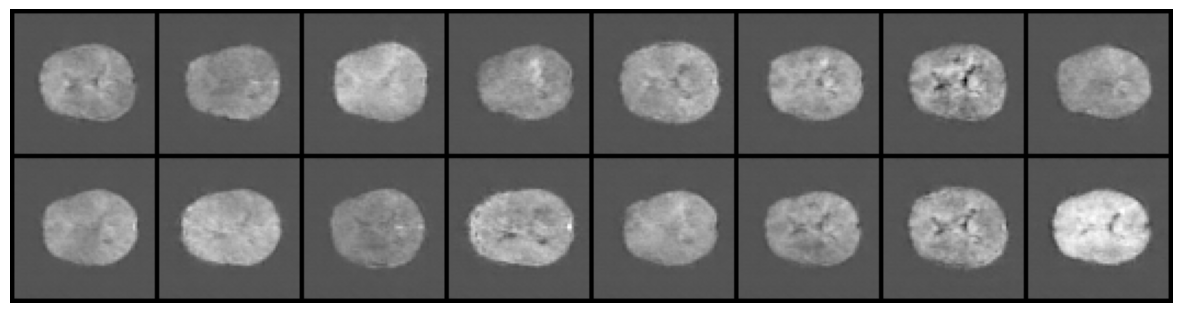

In [ ]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "/content/drive/MyDrive/data/T1"

# Load model and perform inference
netD = Discriminator().to(device)
netD.apply(weight_init)
print(netD)

netG = Generator().to(device)
netG.apply(weight_init)
print(netG)

netD.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
netG.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

netG.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")